### Import Libraries and environment variables setup

In [1]:
import os
import load_dotenv
import nest_asyncio
nest_asyncio.apply()
load_dotenv.load_dotenv()
import asyncio
from playwright.async_api import async_playwright
from langchain_aws import ChatBedrock
from langchain_core.tools import Tool
from langchain_core.documents import Document
from langchain_google_community import GoogleSearchAPIWrapper
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.constants import Send
from langchain_community.document_transformers import Html2TextTransformer
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image
from sentence_transformers import SentenceTransformer, util

/opt/miniconda3/envs/aws_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### LLM Setup

In [2]:
llm = ChatBedrock(
    model_id="us.anthropic.claude-3-5-sonnet-20241022-v2:0",
    model_kwargs=dict(temperature=0.2),
)

In [ ]:
llm.invoke("hi").content

### Structured output llms definition

In [4]:
from typing import Annotated, List, TypedDict, operator, Dict, Optional, Tuple
from pydantic import BaseModel, Field

class Product(BaseModel):
    product_id: Optional[str] = Field(None, description="Unique product identifier.")
    name: str = Field(None, description="Standardized product name.")
    brand: str = Field(None, description="Brand information.")
    model_number: Optional[str] = Field(None, description="Product model number.")
    description: str = Field(None, description="Product description.")
    specifications: Dict[str, str] = Field(None, description="Detailed product specifications.")
    product_variants: Optional[List[Dict]] = Field(None, description="Product variants detail."),
    images: List[str] = Field(None, description="List of high-quality product image URLs.")
    category: str = Field(None, description="Product category.")
    subcategory: str = Field(None, description="Product subcategory.")
    price_range: Tuple[float, float] = Field(None, description="Pricing reference range (min, max).")
    price_unit: str = Field(None, description="Currency unit for pricing.")
    ref_link: str = Field(None, description="Reference link to the product page.")

class ProductListing(BaseModel):
    products: List[Product] = Field(None, description="Product list with details for given category.")

class SearchQuery(BaseModel):
    search_query: str = Field(None, title="Search Query", description="Query that is optimized for search engines")
    justification: str = Field(None, title="Justification", description="Why this query is relevant for the user's request")
 
product_llm = llm.with_structured_output(Product)
search_query_llm = llm.with_structured_output(SearchQuery)

/opt/miniconda3/envs/aws_env/lib/python3.12/site-packages/pydantic/json_schema.py:2279: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=False, default=None, description='Product variants detail.'),) is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)


In [5]:
import pandas as pd
from typing import List
def save_products_in_csv(products: List[Product], file_path: str) -> None:
    """
    Save the product list to a CSV file.
    """
    df = pd.DataFrame([product.model_dump() for product in products])
    df.to_csv(file_path, index=False)

### Langgraph State Definition

In [6]:
# Graph State
class State(TypedDict):
    search_query: str
    product_listing_links: list
    category_name: str
    category_type: str
    products: List[Product]
    product_detail_page_links: Annotated[list, operator.add]
    completed_products: Annotated[list, operator.add] # all workers write to this in parallel

class ProductDetailPageLinkWorkerState(TypedDict):
    category_name: str
    product_listing_link: str
    product_detail_page_links: Annotated[list, operator.add]

class WorkerState(TypedDict):
    link: str
    products: List[Product]
    completed_products: Annotated[list, operator.add]

### Langgraph Function and Tools Define

In [12]:
search = GoogleSearchAPIWrapper()
def top_results(query):
    return search.results(query, 10, {
        "gl": "in",
        "cr": "countryIN",
        "hl": "en",
    })

tool = Tool(
    name="Google Search Snippets",
    description="Search Google for recent results.",
    func=top_results,
)

In [14]:
async def scrape(link: str):
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()
        await page.goto(link, wait_until="domcontentloaded", timeout=0)
        # await page.goto(link, wait_until="networkidle", timeout=0)

        html = await page.content()
        await browser.close()
        return html

In [15]:
def compare_strings(str1: str, str2: str, model_name: str = "all-MiniLM-L6-v2") -> float:
    """
    Compare two strings using a Hugging Face Sentence Transformer model and return the similarity score.
    
    Args:
        str1 (str): First string.
        str2 (str): Second string.
        model_name (str): Name of the pre-trained sentence transformer model.
                          Default is "all-MiniLM-L6-v2".

    Returns:
        float: Cosine similarity score between the two strings (range: 0 to 1).
    """
    model = SentenceTransformer(model_name)
    embeddings = model.encode([str1, str2], convert_to_tensor=True)
    similarity = util.pytorch_cos_sim(embeddings[0], embeddings[1]).item()
    return similarity

### Langgraph Nodes Define

In [22]:
# Nodes
class CategoryType(BaseModel):
    category_type: str = Field(None, title="Category Type", description="Type of category one of [generic, brand]")

def check_brand_category_type(state: State):
    print("started.....")
    result = llm.with_structured_output(CategoryType).invoke(f"Check if {state['category_name']} is a brand product category or generic category.")
    print(result)
    return {"category_type": result.category_type}
    
def continue_or_stop(state: State):
    if state["category_type"] == "brand":
        return "get_search_engine_query"
    else:
        return END

def get_search_engine_query(state: State):
    search_query = llm.with_structured_output(SearchQuery).invoke(
        f"Get a simple user search query for {state['category_name']} category to find pages for product listing."
        )
    print(search_query)
    return {"search_query": search_query.search_query + " in india." }

class ProductListingPageLinks(BaseModel):
    links: list = Field(None, description="Product listing page links relevant to provided brand category name.")

def get_product_listing_page_links(state: State):
    product_listing_links = state.get('product_listing_links')
    if product_listing_links is None or len(product_listing_links) == 0:
        results = tool.run(state["search_query"])
        print(results)
        links = llm.with_structured_output(ProductListingPageLinks).invoke(
            f"Filter out product listing page links relevant to {state['category_name']} category in search results. results: {results}"
        )
        product_listing_links = links.links
        print("google search product listing links: ", product_listing_links)
    return {"product_listing_links": product_listing_links}

class PdpLinkPages(BaseModel):
    pdp_links: list = Field(None, description="Product detail page links relevant to provided product listing page links.")

def scrap_and_get_pdp_links(worker_state: ProductDetailPageLinkWorkerState):
    try:
        html = asyncio.run(scrape(worker_state["product_listing_link"]))
        html_transformer = Html2TextTransformer(ignore_links=False)
        docs_transformed = html_transformer.transform_documents([Document(page_content=html)])
        content = docs_transformed[0].page_content
        # print(content)
        
        product_detail_page_links = llm.with_structured_output(PdpLinkPages).invoke(
            [
                SystemMessage(content="You are proudct detail page url collector from given raw content."),
                HumanMessage(content=f"Give proper formatted list of product detail page links in following content belonging to {worker_state['category_name']} category if present else empty list: {content}")
            ]
        )
        domain_name = worker_state["product_listing_link"].split("/")[2]
        product_detail_page_links.pdp_links = [link if "http" in link else f"https://{domain_name}{link}" for link in product_detail_page_links.pdp_links]
        return {"product_detail_page_links": product_detail_page_links.pdp_links}
    except Exception as e:
        print(str(e))
        return {"error": str(e)}

def get_product_detail_page_links(state: State):
    if len(state["product_listing_links"]) > 0:
        print("Product Listing Page Links")
        print(state["product_listing_links"])
    return [Send("scrap_and_get_pdp_links", {"product_listing_link": link, "category_name": state["category_name"]}) for link in state["product_listing_links"]]

def scrap_and_get_products(worker_state: WorkerState):
    try:
        html = asyncio.run(scrape(worker_state["link"]))
        html_transformer = Html2TextTransformer(ignore_images=False)
        docs_transformed = html_transformer.transform_documents([Document(page_content=html)])
        content = docs_transformed[0].page_content
        
        product_result = product_llm.invoke(
            [
                SystemMessage(content="You are product detail extractor from given raw content."),
                HumanMessage(content=f"Give proper product detail in following content: {content}")
            ]
        )
        if product_result.images is not None:
            product_result.images = [image if "http" in image else f"https://{worker_state['link'].split('/')[2]}{image}" for image in product_result.images]
        
        product_result.ref_link = worker_state["link"]
        return {"completed_products": [product_result]}
    except Exception as e:
        print(str(e))
        return {"error": str(e)}

def assign_workers_to_links(state: State):
    if len(state["product_detail_page_links"]) > 0:
        print("Product Detail Page Links")
        print(state["product_detail_page_links"])
    return [Send("scrap_and_get_products", {"link": link}) for link in state["product_detail_page_links"]]

def synthesizer(state: State):
    unique_products = [] # based on model number
    for product in state["completed_products"]:
        if product.model_number is None or product.model_number not in [p.model_number for p in unique_products]:
            unique_products.append(product)
            
    # unique_products1 = [] 
    # compare products based on name and description and save them in unique_products1
    # for product in unique_products:
    #     if product.name is None or product.description is None:
    #         continue
    #     if len(unique_products1) == 0:
    #         unique_products1.append(product)
    #     else:
    #         for p in unique_products1:
    #             similarity = compare_strings(product.name, p.name)
    #             if similarity < 0.8:
    #                 unique_products1.append(product)
    #                 break
    
    return {
        "products": unique_products
    }

### Compiling Langgraph

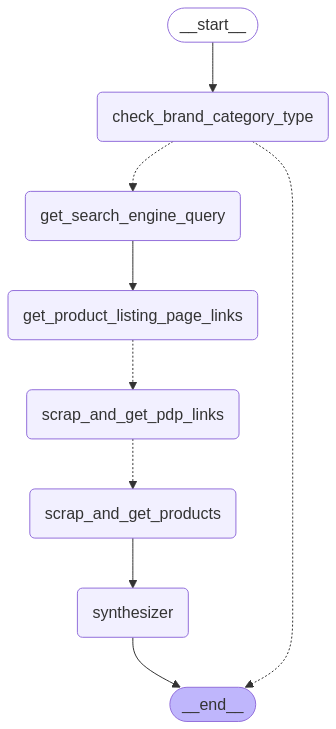

In [23]:
# Build workflow
b2b_products_repo_builder = StateGraph(State)

# Add the nodes
b2b_products_repo_builder.add_node("check_brand_category_type", check_brand_category_type)
b2b_products_repo_builder.add_node("get_search_engine_query", get_search_engine_query)
b2b_products_repo_builder.add_node("get_product_listing_page_links", get_product_listing_page_links)
b2b_products_repo_builder.add_node("scrap_and_get_pdp_links", scrap_and_get_pdp_links)
b2b_products_repo_builder.add_node("scrap_and_get_products", scrap_and_get_products)
b2b_products_repo_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
b2b_products_repo_builder.add_edge(START, "check_brand_category_type")
b2b_products_repo_builder.add_conditional_edges('check_brand_category_type', continue_or_stop, {
    "get_search_engine_query": 'get_search_engine_query',
    END: END
})
b2b_products_repo_builder.add_edge("get_search_engine_query", "get_product_listing_page_links")
b2b_products_repo_builder.add_conditional_edges(
    "get_product_listing_page_links", get_product_detail_page_links, ["scrap_and_get_pdp_links"]
)
b2b_products_repo_builder.add_conditional_edges(
    "scrap_and_get_pdp_links", assign_workers_to_links, ["scrap_and_get_products"]
)
b2b_products_repo_builder.add_edge("scrap_and_get_products", "synthesizer")
b2b_products_repo_builder.add_edge("synthesizer", END)

# Compile the workflow
b2b_products_repo = b2b_products_repo_builder.compile()

# Show the workflow
display(Image(b2b_products_repo.get_graph().draw_mermaid_png()))

In [32]:
state = b2b_products_repo.invoke({
    "category_name": "Dell i5 13th generation laptops",
    "product_listing_links": [],
})

started.....
category_type='brand'
search_query='Dell laptop Intel Core i5 13th gen' justification="This search query is optimized to find Dell laptops specifically equipped with 13th generation Intel Core i5 processors. It includes the essential keywords (Dell, laptop, i5, 13th gen) that would typically return product listings from various retailers and Dell's own website."
[{'title': '13th Gen Intel Core Dell Laptop Computers & 2-in-1s | Dell India', 'link': 'https://www.dell.com/en-in/shop/dell-laptops/scr/laptops/appref=13th-gen-intel-core-processor-generation', 'snippet': 'Dell laptops with 13th Gen Intel® Core™ processors: Power, performance, and innovation for your most demanding tasks.'}, {'title': 'Buy Dell Inspiron 15 3530 Intel Core i5 13th Gen Thin & Light ...', 'link': 'https://www.croma.com/dell-inspiron-15-3530-intel-core-i5-13th-gen-thin-light-laptop-16gb-512gb-ssd-windows-11-home-15-6-inch-full-hd-wva-ips-display-ms-office-home-student-2021-platinum-silver-1-62-kg-/p/3

In [33]:
state['products']

[Product(product_id=None, name='Inspiron 14 Laptop', brand='Dell', model_number='5440', description='A versatile 14-inch laptop featuring 13th Gen Intel Core processors, Windows 11, and a FHD+ display with anti-glare technology.', specifications={'processor': '13th Gen Intel® Core™ i3-1305U (5 cores, up to 4.5 GHz)', 'operating_system': 'Windows 11 Home Single Language, English', 'graphics': 'Intel® UHD Graphics', 'memory': '8 GB: 1 x 8 GB, DDR5, 4400 MT/s', 'storage': '512GB M.2 PCIe NVMe Solid State Drive', 'display': '14", Non-Touch, FHD+ 1920x1200, 60Hz, IPS, WVA, Anti-Glare, 250 nit, ComfortView', 'color': 'Ice Blue Plastic Cover', 'keyboard': 'Ice Blue English International backlit keyboard', 'camera': '720p at 30 fps HD RGB camera, Single microphones', 'battery': '3 Cell, 41 Wh, integrated', 'weight': 'Starting from 1.54 kg', 'wireless': 'Realtek Wi-Fi 6 RTL8851BE, 1x1, 802.11ax, MU-MIMO, Bluetooth'}, product_variants=(FieldInfo(annotation=NoneType, required=False, default=None,

In [21]:
save_products_in_csv(state["products"], f"brand-products/{state['category_name']}.csv")

/opt/miniconda3/envs/aws_env/lib/python3.12/site-packages/pydantic/main.py:426: UserWarning: Pydantic serializer warnings:
  Expected `list[dict[any, any]]` but got `tuple` with value `(FieldInfo(annotation=Non...uct variants detail.'),)` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
